# Material Stream Identification (MSI) - Mini End-to-End Demo

## 1. Introduction

**Material Stream Identification (MSI)** is a key component in automated recycling and sorting systems. It involves identifying the type of material (e.g., Plastic, Metal, Paper, Trash) passing through a waste stream using computer vision.

This notebook demonstrates a **simplified, classical Machine Learning pipeline** for MSI.

### **What this pipeline does:**
1.  **Synthetic Data Generation**: Creates a dataset of "Plastic" (Rectangles), "Metal" (Circles), and "Trash" (Noise) images.
2.  **Preprocessing**: Grayscale conversion and normalization.
3.  **Feature Extraction**: Uses **HOG (Histogram of Oriented Gradients)** to convert images into numerical feature vectors.
4.  **Model Training**: Trains a Support Vector Machine (SVM) classifier.
5.  **Unknown Handling**: Implements a confidence threshold to reject uncertain predictions.
6.  **Real-Time Inference**: Connects to the webcam (or simulates a stream) to predict materials live.

---

## 2. Imports & Setup

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings
import random
import time

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Synthetic Dataset Generation

We will generate 3 classes of images (64x64 pixels):
- **Class 0 (Plastic)**: Bright Rectangles
- **Class 1 (Metal)**: Dark Circles
- **Class 2 (Trash)**: Random Noise

In [ ]:
def create_blank_image(size=64):
    return np.zeros((size, size, 3), dtype=np.uint8)

def generate_plastic(size=64):
    """Generates a bright rectangle on a dark background."""
    img = create_blank_image(size)
    # Random rectangle properties
    pt1 = (random.randint(5, 20), random.randint(5, 20))
    pt2 = (random.randint(30, 55), random.randint(30, 55))
    color = (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))
    cv2.rectangle(img, pt1, pt2, color, -1)
    return img

def generate_metal(size=64):
    """Generates a dark circle on a grayish background."""
    img = create_blank_image(size) + np.uint8(random.randint(100, 150)) # Grayish background
    center = (random.randint(20, 44), random.randint(20, 44))
    radius = random.randint(10, 18)
    color = (random.randint(0, 80), random.randint(0, 80), random.randint(0, 80)) # Dark color
    cv2.circle(img, center, radius, color, -1)
    return img

def generate_trash(size=64):
    """Generates random noise."""
    return np.random.randint(0, 255, (size, size, 3), dtype=np.uint8)

# Create Dataset
X_raw = []
y_raw = []
classes = ['Plastic', 'Metal', 'Trash']
samples_per_class = 100

print("Generating Dataset...")
for _ in range(samples_per_class):
    X_raw.append(generate_plastic())
    y_raw.append(0)
    
    X_raw.append(generate_metal())
    y_raw.append(1)
    
    X_raw.append(generate_trash())
    y_raw.append(2)

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)

print(f"Dataset Shape: {X_raw.shape}")
print(f"Labels Shape: {y_raw.shape}")

Generating Dataset...
Dataset Shape: (300, 64, 64, 3)
Labels Shape: (300,)


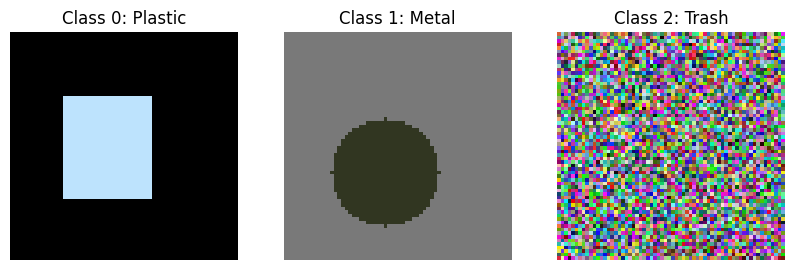

In [ ]:
# Visualize Samples
plt.figure(figsize=(10, 4))
for i in range(3):
    # Find first index of each class
    idx = np.where(y_raw == i)[0][0]
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(X_raw[idx], cv2.COLOR_BGR2RGB))
    plt.title(f"Class {i}: {classes[i]}")
    plt.axis('off')
plt.show()

## 4. Preprocessing & 5. Feature Extraction

**Preprocessing:**
- **Resize**: Ensure all images are 64x64 (already done slightly, but good to enforce).
- **Grayscale**: Color often varies due to lighting; texture and shape are more robust.

**Feature Extraction (HOG):**
- **HOG (Histogram of Oriented Gradients)** counts occurrences of gradient orientation in localized portions of an image.
- It is a powerful descriptor for shape and texture, commonly used in pedestrian detection before deep learning.

In [ ]:
def preprocess_image(img, size=(64, 64)):
    """Converts to grayscale and resizes."""
    if img.shape[0] != size[0] or img.shape[1] != size[1]:
        img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

# HOG Setup
winSize = (64, 64)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

def extract_features(img):
    """Preprocesses and extracts HOG features."""
    gray = preprocess_image(img)
    # cv2.HOGDescriptor returns a flattened 1D array
    features = hog.compute(gray)
    return features.flatten()

# Test on one image
sample_feat = extract_features(X_raw[0])
print(f"Feature Vector Shape: {sample_feat.shape}")

Feature Vector Shape: (1764,)


## 6. Dataset Preparation

Convert all raw images into feature vectors.

In [ ]:
X_features = []
for img in X_raw:
    X_features.append(extract_features(img))

X_features = np.array(X_features)

# Split into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_features, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (240, 1764)
Validation set: (60, 1764)


## 7. Model Training

We use an **SVM (Support Vector Machine)** with an RBF kernel.
- SVM is excellent for high-dimensional feature spaces (like HOG).
- `probability=True` allows us to get confidence scores for unknown handling.

In [ ]:
print("Training SVM...")
model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
accuracy = accuracy_score(y_val, val_preds)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_val, val_preds, target_names=classes))

Training SVM...
Validation Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

     Plastic       1.00      1.00      1.00        20
       Metal       1.00      1.00      1.00        20
       Trash       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



## 8. Unknown Class Handling

In a real facility, foreign objects might appear. We shouldn't misclassify them as valid materials confidently.

**Logic:**
- Get prediction probability.
- If the maximum probability across all classes is **below a threshold** (e.g., 0.6), classify as **Unknown**.

In [ ]:
CONFIDENCE_THRESHOLD = 0.6

def predict_frame(frame):
    """
    Takes a BGR image (frame), predicts class, and handles uncertainty.
    Returns: label_text, confidence
    """
    # 1. Feature Extraction
    try:
        feats = extract_features(frame)
    except Exception as e:
        return "Error", 0.0
        
    # 2. Reshape for sklearn (1, n_features)
    feats = feats.reshape(1, -1)
    
    # 3. Prediction scores
    probs = model.predict_proba(feats)[0]
    max_prob = np.max(probs)
    pred_idx = np.argmax(probs)
    
    # 4. Unknown Rejection
    if max_prob < CONFIDENCE_THRESHOLD:
        return "Unknown", max_prob
    else:
        return classes[pred_idx], max_prob

## 9. Real-Time Visualization (End-to-End)

This loop captures video from the webcam, processes each frame, and overlays the prediction.

**Instructions:**
- Press **'q'** to quit the video stream.
- Hold up objects (or pictures on your phone) that look like the synthetic data:
    - **Plastic**: Bright rectangular object
    - **Metal**: Dark circular object
    - **Trash**: High texture / messy object
    
*(Note: Since the model was trained on simple synthetic data, real-world performance will be basic, but it demonstrates the pipeline mechanics.)*

In [ ]:
cap = None
# Try indices 0, 1, and 2 to find the correct camera
for idx in [0, 1, 2]:
    print(f"Checking camera index {idx}...")
    temp = cv2.VideoCapture(idx)
    if temp.isOpened():
        cap = temp
        print(f"Success: Connected to camera {idx}")
        break

if cap is None or not cap.isOpened():
    print("Error: Could not open any video source.")
    print("1. Check if another app (Zoom/Teams) is using the camera.")
    print("2. Check privacy settings (allow apps to access camera).")
else:
    print("Starting Video Stream... Press 'q' to exit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        # --- INFERENCE STEP ---
        label, conf = predict_frame(frame)

        # --- VISUALIZATION ---
        color_map = {
            'Plastic': (0, 255, 0),   # Green
            'Metal': (255, 0, 0),     # Blue
            'Trash': (0, 0, 255),     # Red
            'Unknown': (200, 200, 200),
            'Error': (0, 0, 255)
        }

        col = color_map.get(label, (255, 255, 255))

        # Draw UI
        cv2.putText(frame, f"Material: {label}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, col, 2)
        cv2.putText(frame, f"Conf: {conf:.2f}", (20, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2)

        cv2.imshow("MSI Demo System", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print("Stream stopped.")

Checking camera index 0...
Success: Connected to camera 0
Starting Video Stream... Press 'q' to exit.
Stream stopped.
